# 神经网络初步

在监督学习中，我们的目标是使用特征$x$的函数，$f(x)$，对某个输出$y$进行拟合。我们之前所学的线性回归、非线性回归、Logistic回归等方法都可以看作是设定了一个$f(x)$的函数形式：$f(x,\theta)$，通过最小化损失的方式找到一个$\theta^*$使得$f(x,\theta^*)$的预测最准确。而分类树、支持向量机等方法则是寻求非参数的方法确定$f(x)$。

而**神经网络**（**neural networks**）则是使用了第一种方法的思想，不过为了减轻函数形式的假设，通过模拟生物的神经系统的方法，组合大量的“**神经元**（**neuron**）”，找到了一族非常特殊而又具有极强表达模型能力的函数形式。从这点而言，简单的神经网络模型其实与我们所学的回归模型等方法并没有本质上的不同，只不过神经网络使用了神经元的网络结构构造了更加灵活的函数形式而已。

最常用、最简单的神经网络是所谓**深度前馈网络**（**deep feed-forward networks**）或者**多层感知机**（**multilayer perceptrons, MLP**）。所谓“前馈”，即从输入（input），通过一定的计算得到隐含变量，最后再进行计算得到输出（output）的过程，而没有反馈（feedback）。

其中，隐含变量是通过输入计算得到的，我们通常称其为**隐含层**（**hidden layer**），比如一个简单的单层网络：
![](pic/nn_1_hidden.gv.png "单层前馈网络")
其中第一层为输入层（input layer），中间一层使用输入层得到了隐含层（hidden layer），最后一层使用隐藏层计算了输出层（output layer）。此外注意输出层可以不止有一个输出，可以由更多的输出，就像我们在计量经济学中的系统估计、多元Probit、多元Logistic等一样，将紧密相关的几个不同输出放在一个模型中进行训练会给模型带来更多的信息。

当然，也可以继续加入隐含层，比如以下是一个二层网络：
![](pic/nn_2_hidden.gv.png "双层前馈网络")
在以上单层网络的基础上，我们又加入了一个隐含层，就变成了双层前馈网络。以上过程还可以继续，隐含层的层数我们将其称之为这个网络的**深度**（**depth**），所以“深度学习”的简单理解就是深度比较高的神经网络。

其中，隐含层的每一个节点都是一个神经元。所谓神经元，就是使用输入通过一定的函数计算得到一个输出。观察以上的两个网络，每一个隐含层都会使用上一层的所有输出作为这一层的输入，而且不存在跨层，我们称这类网络为**全连接网络**（**fully-connected**）。每一层的神经元的个数成为“**宽度**”（**width**）。

如果我们记$f_{li}\left(h_{l-1}\right)$记为该函数，其中$h_{l-1}$为第$l-1$层的输出，而$f_{li}$则为第$l$层的第$i$个神经元，$h_{0}$即为输入$x$，同时记$$f_l\left(h_{l-1}\right)=\left[f_{l1},f_{l2},...,f_{l,K_l}\right]'$$其中$K_l$为第$l$层的神经元个数，那么神经网络可以使用一个嵌套函数：$$y=f_L\left(f_{L-1}\left(f_{L-2}\left(\cdots f_1\left(x\right)\right)\right)\right)$$值得注意的是，从以上公式中我们可以看出，所有的函数并不能是线性函数：如果所有的$f$都是线性函数，那么最终整个模型也不过就是一个线性函数而已。所以一般而言，每个神经元的计算函数$f_{li}$不能取线性函数。我们将在下面详细介绍神经元的构建。

所有的神经元构成了一个有向无环图，给定一个**损失函数**（**loss function**），比如$$\sum_{i=1}^N ||y_i-\hat{y_i}||_2$$其中$\hat{y_i}$为神经网络的预测，那么最小化以上损失函数就可以得到$f_{li}$的估计，从而最终得到预测函数。而正如前面所学的，为了最小化以上的损失函数，通常使用梯度下降法，而计算导数的过程是逆向求导的：求导的方向是从输出层到输入层，所以求解该最优化问题的方法也叫做“**反向传播**”（**back-propagation**，简称**BP**）算法。

而这个过程完全可以使用PyTorch进行：我们只需要将计算图表达出来，利用PyTorch的自动求导功能，并使用PyTorch中的各种优化方法，就可以找到$\hat{y_i}$的最优参数。

根据**万能近似定理**（**universal approximation theorem**），具有足够多隐藏神经元的网络（具有足够深度、宽度）可以逼近任何的Borel可测特别是连续函数。当然，逼近的效果取决于网络的结构，包括宽度、深度以及神经元的设计。接下来我们将主要介绍神经网络的结构设计。在此之前，我们不妨先通过一个简单的例子理解神经网络的工作原理。

# 一个简单的例子：学习异或函数

**异或函数**（**XOR**）是一个常用的逻辑函数，其定义为：$$0\ \ XOR\ \ 0=0 \\ 1\ \ XOR\ \ 0=1 \\ 0\ \ XOR\ 1\ =1 \\ 1\ \ XOR\ \ 1=0$$即如果两个输入全是0或者全是1，则输出为0；只有当两个输入中一个为1一个为0时，输出为1。

比如，我们可以先生成一组随机的数据：

In [1]:
import numpy as np

N=1000
X=np.random.random((N,2))>0.5
X=X.astype('int32')
X

array([[1, 1],
       [0, 0],
       [0, 0],
       ...,
       [0, 0],
       [0, 0],
       [0, 1]], dtype=int32)

注意为了放到PyTorch中我们将数值类型转化为Float32，然后生成标签：

In [2]:
Y=((X.sum(axis=1))==1).astype('float32')
X=X.astype('float32')
Y[0:10]

array([0., 0., 0., 1., 1., 1., 1., 1., 0., 0.], dtype=float32)

我们使用了函数$y=1\left\{x_1+x_2==1\right\}$生成$y$，然而注意到以上函数并不是一个线性函数。

我们不妨使用一个简单的只有一层隐含层，两个隐含神经元的网络：
![](pic/nn_xor_hidden.gv.png "学习异或")

可以想象，如果我们令：$$h_1=b_{10}+b_{11}x_1+b_{12}x_2 \\ h_1=b_{20}+b_{21}x_1+b_{22}x_2 \\ y=b_0+b_1 h_1+b_2 h_2$$那么$$y=b_0+b_1\left(b_{10}+b_{11}x_1+b_{12}x_2\right)+b_2\left(b_{20}+b_{21}x_1+b_{22}x_2\right)$$仍然是一个线性函数，不可能学习到异或函数。

为此，我们转而将以上函数取为非线性函数，比如，一个简单的方法是使用**激活函数**（**activation function**），即把来自于上一层的输出的线性组合，通过一个一元非线性函数变换得到该神经元的输出。比如，一个常用的激活函数是**线性整流函数**（**Rectified Linear Unit**, **ReLU**）：$$g\left(x\right)=\begin{cases}
0 & x<0\\
x & x\geq0
\end{cases}$$
该函数是一个**分段**（**piecewise**）函数，函数图像为：
![](pic/ReLU.png "ReLU函数")

使用该函数，我们可以将其写为：$$h_1=g\left(b_{10}+b_{11}x_1+b_{12}x_2\right) \\ h_1=g\left(b_{20}+b_{21}x_1+b_{22}x_2\right) \\ y=b_0+b_1 h_1+b_2 h_2$$
观察数据生成过程$y=1\left\{x_1+x_2==1\right\}$可以看到，$y$的生成依赖于两个$x$相加，我们不妨猜测$b_{11}=b_{12}=b_{21}=b_{22}=1$，从而得到：$$h_1=g\left(b_{10}+x_1+x_2\right) \\ h_1=g\left(b_{20}+x_1+x_2\right) \\ y=b_0+b_1 h_1+b_2 h_2$$对于输入：$$\left[\begin{array}{cc}
0 & 0\\
0 & 1\\
1 & 0\\
1 & 1
\end{array}\right]$$正确的输出结果为：$$\left[\begin{array}{c}
0\\
1\\
1\\
0
\end{array}\right]$$第一步经过相加后，输入就变成了：$$\left[\begin{array}{c}
0\\
1\\
1\\
2
\end{array}\right]$$我们可以先结合ReLU函数的特点，把两个特殊的值：$0,2$取出来，比如，可以令$b_{10}=-0.5,b_{20}=-1$，经过计算后得到：结果分别为：$$\left[\begin{array}{c}
-0.5\\
0.5\\
0.5\\
1.5
\end{array}\right]\left[\begin{array}{c}
-1\\
0\\
0\\
1
\end{array}\right]$$经过ReLU函数的激活就变成了：$$\left[\begin{array}{c}
0\\
0.5\\
0.5\\
1.5
\end{array}\right]\left[\begin{array}{c}
0\\
0\\
0\\
1
\end{array}\right]$$注意到：$$2\left[\begin{array}{c}
0\\
0.5\\
0.5\\
1.5
\end{array}\right]-3\left[\begin{array}{c}
0\\
0\\
0\\
1
\end{array}\right]=\left[\begin{array}{c}
0\\
1\\
1\\
0
\end{array}\right]$$从而，令$b_0=0,b_2=2,b_3=-3$就可以得使得以上网络能够学习到异或函数了。当然，从统计学角度，以上的所有参数都是不可识别的：有不止一组解能够达到与以上参数相同的结果。所以实际数据计算的结果可能会与以上结果有偏差，但是预测结果应该是一样的。

结合以上例子，对于神经网络的一个最简单的理解就是：每一个神经元就像一个小“开关”一样，当该神经元的输入（线性组合）达到了一定的阈值，那么就处于开启的状态（激活了），否则就处于关闭的状态。我们可以通过很多很多这样的小开关来判断当期的状态，进而判断此时的$y$的值。

我们可以使用PyTorch对以上数据进行训练，首先准备数据：

In [3]:
import torch
from torch.utils.data import Dataset,DataLoader

class xor_data(Dataset):
    def __len__(self):
        return X.shape[0]
    def __getitem__(self, i):
        x=X[i,:]
        y=Y[i]
        data=torch.from_numpy(x)
        label=torch.tensor(y)
        return data, label
data=xor_data()
xor_dl=DataLoader(data, batch_size=data.__len__(), pin_memory=True)

In [4]:
import torch.optim as optim
# 设置初始值
b1=torch.rand(3, requires_grad=True)
b2=torch.rand(3, requires_grad=True)
b=torch.rand(3, requires_grad=True)
optimizer=optim.Adagrad([b1,b2,b], lr=0.01)
Zero=torch.tensor(0.0)
for i in range(100):
    for x,y in xor_dl:
        xb1=torch.mv(x,b1[:-1])+b1[-1]
        xb1=torch.max(Zero,xb1)
        xb2=torch.mv(x,b2[:-1])+b2[-1]
        xb2=torch.max(Zero,xb2)
        xb=b[0]*xb1+b[1]*xb2+b[2]
        loss=torch.sum((y-xb)**2)
        # 梯度清零
        optimizer.zero_grad()
        # 计算梯度
        loss.backward()
        # 迭代
        optimizer.step()
print(b1)
print(b2)
print(b)

tensor([0.3053, 0.0965, 0.8282], requires_grad=True)
tensor([4.2062e-01, 3.1043e-03, 1.5470e-04], requires_grad=True)
tensor([ 0.4682,  0.3533, -0.0162], requires_grad=True)


以上我们使用了前面所学的PyTorch的计算图对以上模型进行了计算。然而在大型的神经网络中，如果使用以上方法一个个定义参数，将会非常麻烦。PyTorch中，可以使用神经网络工具箱torch.nn使用简单的编程语言来对以上模型进行建模，就像搭积木一样把整个模型搭建起来。首先导入神经网络工具箱：

In [5]:
from torch import nn
device=torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
# 如果模型放在GPU上，如果计算中出现错误，报错信息不好查看。这个时候可以把模型放在CPU上，报错信息就更加容易查看了
# device=torch.device("cpu")

nn工具箱的具体使用可以查看https://pytorch.org/docs/stable/nn.html ，我们在这里介绍一些主要用法。

为了构建神经网络模型，需要创建一个神经网络模型的类：

In [6]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入2个输出
        self.layer1=nn.Sequential(nn.Linear(2,2),nn.ReLU(inplace=True))
        # 第二层：线性组合，2个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(2,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)

我们解释一下上面的类。首先，该类继承自nn.Module，nn.Module是一个抽象类，我们需要将该类的函数进行重载从而定义模型。

接下来，使用：
```python
super(XOR_net, self).__init__()
```
进行了初始化。

nn.Sequential()可以看做是创建了一个计算的“容器”，即按照顺序对输入进行处理，并得到输出。其中，nn.Linear(m,n)即构建一个线性组合，有m个输入以及n个输出。而nn.ReLU即对上一层的计算结果进行ReLU的变换。

使用如上的方法，我们构造了两个层，第一层有2个输入2个输出，第二层有2个输入1个输出。

如果需要给每个层命名，在构造Sequantial时也可以使用有序词典：
```python
self.layer1=nn.Sequential(OrderedDict([
            ('Layer1_linear_combine', nn.Linear(2,2)),
            ('Layer1_ReLU', nn.ReLU(inplace=True))
        ]))
```


接下来，定义forward()方法，将输入x通过不同层的计算得到输出的前向传播过程。

如此我们就定义了一个简单的网络。

接下来，可以继续定义损失函数，并进行迭代：

Parameter containing:
tensor([[ 0.2928, -0.1487],
        [-0.3193, -0.0763]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.4632, -0.6723], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-0.0649, -0.3756]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.5210], device='cuda:0', requires_grad=True)


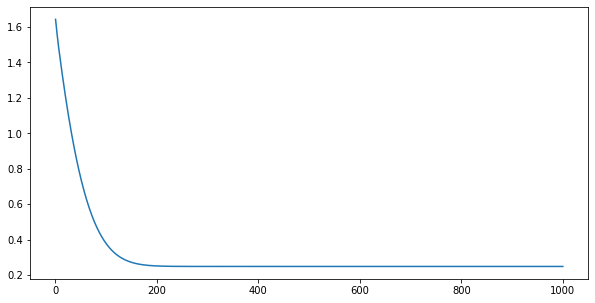

In [7]:
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(1000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

注意由于预测出来的y_pred是一个列向量，而y本身是一个行向量，所以我们使用unsqueeze()方法将其转化为列向量，这样才能正确计算损失。否则，损失的计算将根据广播的计算法法进行计算。

接下来，可以使用该模型进行预测，比如

In [8]:
X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

tensor([[0.5210],
        [0.5210],
        [0.5210],
        [0.5210]], device='cuda:0', grad_fn=<AddmmBackward>)


注意在预测前我们将模型改为了预测模式：
```python
model.eval()
```
这么做的目的是为了告诉模型我们并不是在训练模型。对于简单模型来说这一步不是必须，但是如果我们加入了Dropout层之类，就会有比较大差异了，所以一个好的习惯是做预测时都将其改成预测模式。

关闭预测模式，打开训练模式需要：
```python
model.train()
```
即可。

注意到以上模型效果有时不太理想。实际上现在我们的数据是确定性的：输出和输入之间是函数关系，没有误差。而且，根据我们之前对网络设计的讨论，该网络完全可以学习到这个函数。然而现实情况确是预测误差很大。

这也就是我们在神经网络里面遇到的问题：网络结构是非线性的，其性质很多时候取决于网络的结构和使用的激活函数的性质，非常有可能存在大量的鞍点、局部最优点等等。这些问题的存在会使得我们多数时候找不到那个最优解。

比如，在这里，虽然ReLU激活函数在理论上我们已经证明了其优异的性质，但是在使用中，由于ReLU函数对于$x<0$的部分，导数为0，这就导致如果我们不小心走进了这部分区域的话，这一块的梯度将会直接等于0，从而对参数的更新方向不带来任何的信息。所以一个好的实践是把ReLU的所有的参数设为正的，从而在初始时就能够有方向信息。

或者，我们可以将ReLU激活函数稍微修改一下，即：**带泄露的线性整流函数**（**Leaky ReLU**）：$$g\left(x\right)=\begin{cases}
\alpha x & x<0\\
x & x\geq0
\end{cases}$$
函数图像为：
![](pic/LeakyReLU.png "Leaky ReLU函数")
一般$\alpha$取比较小的值，比如默认的是0.01，从而即使跑到了小于0的区域，也不会使得梯度直接等于0。我们可以将ReLU激活函数替换成LeakyReLU函数：

Parameter containing:
tensor([[-1.1690,  1.1811],
        [ 1.3753, -1.3905]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0015,  0.3094], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[1.0475, 0.7360]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.2277], device='cuda:0', requires_grad=True)


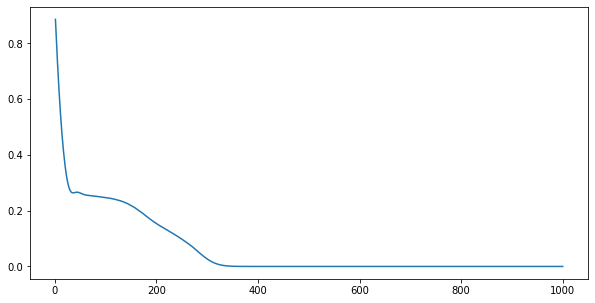

tensor([[-1.0431e-07],
        [ 1.0000e+00],
        [ 1.0000e+00],
        [ 2.0862e-07]], device='cuda:0', grad_fn=<AddmmBackward>)


In [9]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入2个输出
        self.layer1=nn.Sequential(nn.Linear(2,2),nn.LeakyReLU(inplace=True))
        # 第二层：线性组合，2个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(2,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(1000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

可以看到已经有不错的效果。

当然，也可以粗暴的增加网络的宽度，也可以获得不错的效果：

Parameter containing:
tensor([[ 0.1640,  0.4420],
        [-0.2368,  0.1949],
        [ 0.9732, -0.9563],
        [-1.1734,  1.3228],
        [ 0.7771, -0.1613],
        [-0.2254,  0.4774]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1711,  0.7666, -0.0009, -0.0022,  0.2138, -0.5778], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 0.2482,  0.1095,  1.3464,  0.6071, -0.4167, -0.3537]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0374], device='cuda:0', requires_grad=True)


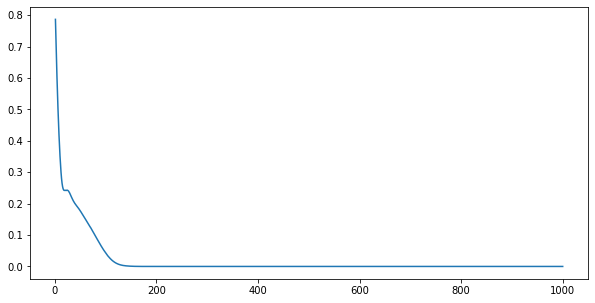

tensor([[-2.6077e-08],
        [ 1.0000e+00],
        [ 1.0000e+00],
        [ 1.1176e-08]], device='cuda:0', grad_fn=<AddmmBackward>)


In [10]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入6个输出
        self.layer1=nn.Sequential(nn.Linear(2,6),nn.ReLU(inplace=True))
        # 第二层：线性组合，6个输入1个输出
        self.layer2=nn.Sequential(nn.Linear(6,1))
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
criterion=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(1000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
for p in model.parameters():
    print(p)
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

# 激活函数

上面我们使用了ReLU函数作为激活函数，该激活函数也被应用在很多神经网络中，而且理论也证明了该激活函数的合理性。然而，该激活函数也有问题，比如对于某些样本，可能会计算得到的梯度为0，从而不提供信息，我们又引入了LeakyReLU激活函数。

实际上还有很多其他的激活函数可以使用。激活函数的设计本身也是神经网络研究里面的一个热门领域。

比如，从ReLU出发:

* 如果把小于0的部分的斜率参数化，即通过算法学习$\alpha$，那么就变成了**参数ReLU**（**PReLU**）
* 如果把小于0的部分的随机化，即令$\alpha\sim U(0,1)$的一个随机变量，那么就变成了**随机化ReLU**（**RReLU**）
* 取$g(x)=\frac{1}{\beta}\ln\left[1+e^{\beta x}\right]$，称为Softplus函数，是对ReLU的一个连续逼近，不过相比较ReLU其表现可能还更差，故一般不建议使用
* 取$g(x)=x*\Phi(x)$，其中$\Phi(x)$为标准正态分布的分布函数，就变成了**正态误差线性整流函数**（Gaussian Error LU, GELU）
* 取$g(x)=x*\sigma(x)=\frac{x}{1+e^{-x}}$，其中$\sigma(x)$为标准Logistic分布的分布函数，就变成了**Sigmoid线性整流函数**（**Sigmoid LU**, **SiLU**）

Softplus, GELU和SiLU都不是分段的，而是逐点的函数（element-wise），其图像如下：
![](pic/GELU.png "GELU函数")

此外，另一类非常常用的激活函数是Sigmoid函数，也就是Logistic分布的分布函数：$\sigma\left(x\right)=\frac{1}{1+e^{-x}}$如果将其做一个简单的变换，就变成了**双曲正切函数**（**hypobolic tangent functin**）：$$tanh\left(x\right)=2\sigma\left(2x\right)-1=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$其图像为：
![](pic/sigmoid.png "Sigmod和tanh函数")

以上两个函数都有同样的特点，即只有在$x$靠近0时导数比较大，而离0比较远的时候，导数接近于0，就没有那么敏感了。Sigmoid函数在ReLU使用之前是最常用的激活函数，然而目前在前馈网络中更多的则是使用ReLU类的激活函数，而其他的一些场合，比如在比如循环神经网络，或者建模概率时，会使用Sigmoid激活函数。

此外，还有ReLU6激活函数，该函数不仅仅在$<0$的部分变成平的，在$>6$的部分也变成平的。还有Tanhshrink函数：$Tanhshrink(x)=x-tanh(x)$，与Sigmoid相反，在0附近斜率比较小，而远离0时斜率比较大，其图像为：
![](pic/relu6.png "ReLU6和Tanhshrink函数")



# 损失函数

除了激活函数外，神经网络的目标函数，也就是损失函数也非常重要。

在XOR的例子中，我们最小化了误差平方和，也就是均方误差：$$MSE\ Loss=\sum_{i=1}^N \left(y_i-\hat{y}_i\right)^2=||y_i-\hat{y}_i||^2_2$$对于连续的输出，这是最自然也是最常用的损失函数。如果从概率论来讲，我们通过MSE的最小化可以得到条件期望的估计$\widehat{\mathbb{E}\left(y_{i}|x_{i}\right)}$。

如果将以上的$L_2$范数换成$L_1$范数，即：$$L_1\ Loss=\sum_{i=1}^N \left|y_i-\hat{y}_i\right|=||y_i-\hat{y}_i||_1$$那么就得到了条件中位数的估计$\widehat{Med\left(y_{i}|x_{i}\right)}$，也是常用的损失函数。

而对于离散的输出，比如二元、多元、计数的输出，我们可以使用类似广义线性模型中的建模技巧，通过极大似然估计建模损失函数。

在广义线性模型中，需要首先使用一个链接函数（link function）对条件期望$\mathbb{E}\left(y_{i}|x_{i}\right)$进行建模，进而使用一个分布，给定条件期望建模$y$的分布：$y|x\sim F\left(\mathbb{E}\left(y_{i}|x_{i}\right)\right)$。从而可以使用极大似然估计，通过最小化：$$-\ln {f\left(\mathbb{E}\left(y_{i}|x_{i}\right)\right)}$$其中$f$为条件密度函数。

比如，对于二元分布，我们可以在最后一层使用Sigmoid激活函数，将上一层的计算结果映射到$p_i\in\left(0,1\right)$之间，假设$y_i|p_i\sim Ber\left(p_i\right)$，从而最小化：$$-\sum_i {\left[y_i \ln (p_i)+(1-y_i)\ln (1-p_i)\right]}$$在PyTorch中，可以使用BCELoss生成该损失函数。比如：

Parameter containing:
tensor([[ 2.5603, -2.7322],
        [-0.5927, -0.1145],
        [-1.3163, -1.3166],
        [-2.8436,  2.7376],
        [ 0.0306, -0.5766],
        [-0.6053,  0.0255]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.1708, -0.6013,  1.3162,  0.1046, -0.4945, -0.2202], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[ 3.8352, -0.0919, -2.7667,  3.6997, -0.2560, -0.1574]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-4.3502], device='cuda:0', requires_grad=True)


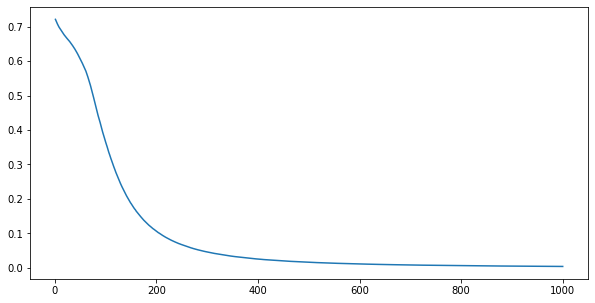

tensor([[9.5811e-04],
        [9.9790e-01],
        [9.9782e-01],
        [1.2740e-02]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [11]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入6个输出
        self.layer1=nn.Sequential(nn.Linear(2,6),nn.ReLU(inplace=True))
        # 第二层：线性组合，6个输入1个输出，注意使用了Sigmoid激活函数映射到(0,1)
        self.layer2=nn.Sequential(nn.Linear(6,1), nn.Sigmoid())
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
# 这里使用BCELoss
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(1000):
    for x,y in xor_dl:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device).unsqueeze(1))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

BCELoss只能解决二元分类，如果需要解决多元分类的问题，可以首先使用Softmax激活函数：$$softmax\left(x\right)_i=\frac{e^{x_i}}{\sum_j{e^{x_j}}}$$其中$x=[x_1,x_2,...,x_J]$，$J$为分类的个数。其实以上设定就是Multinomial Logit的设定，有$$\sum_j{softmax\left(x\right)_j}=1$$

那么，对于$y\in\left\{1,2,...,J\right\}$，极大似然最小化：$$\sum_{i}\sum_{j}1\left\{ y_{i}=j\right\} \cdot softmax\left(x\right)_{j}$$PyTorch中**交叉熵损失函数**——**CrossEntropy**实现了以上损失函数。

或者，注意到：$$\ln \left[softmax\left(x\right)_i\right]=x_i-\ln\left(\sum_j{e^{x_j}}\right)$$我们称以上函数为对数Softmax函数，在PyTorch中有激活函数**LogSoftmax**计算以上函数。

接着，使用**负对数似然损失**（**negative log likelihood loss**）——**NLLLOSS**：$$NLLLoss=-\sum_i l_i$$其中$l_i$为计算出的对数似然函数值，就可以计算出CrossEntropy损失函数。所以CrossEntropy损失函数可以看作是LogSoftmax激活函数和NLLLoss损失函数的组合。

比如，在XOR的例子中，有两个分类，如果我们使用CrossEntropy损失函数，必须有两个输出，所以我们首先修改DataLoader：

In [30]:
class xor_data2(Dataset):
    def __len__(self):
        return X.shape[0]
    def __getitem__(self, i):
        x=X[i,:]
        y=Y[i]
        data=torch.from_numpy(x)
        # 为了使用CrossEntropyLoss，这里的y需要是{0,1,...,J-1}的取值，且必须是Long类型
        label=torch.tensor(y).long()
        return data, label
data2=xor_data2()
xor_dl2=DataLoader(data2, batch_size=data.__len__(), pin_memory=True)

注意CrossEntropyLoss要求标签为long类型，所以我们使用long()将其转化为一个long类型。然后才能使用交叉熵损失函数：

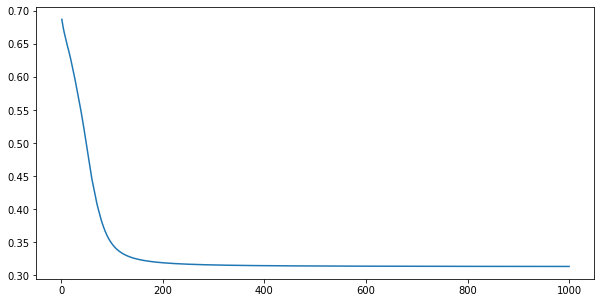

tensor([[9.9933e-01, 6.6502e-04],
        [2.5425e-04, 9.9975e-01],
        [4.5919e-04, 9.9954e-01],
        [9.9965e-01, 3.4528e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)


/usr/local/lib64/python3.6/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [31]:
class XOR_net(nn.Module):
    def __init__(self):
        super(XOR_net, self).__init__()
        # 第一层：线性组合，2个输入6个输出
        self.layer1=nn.Sequential(nn.Linear(2,6),nn.ReLU(inplace=True))
        # 第二层：线性组合，6个输入2个输出，注意使用了Softmax激活函数
        self.layer2=nn.Sequential(nn.Linear(6,2), nn.Softmax())
    def forward(self,x):
        x=self.layer1(x)
        x=self.layer2(x)
        return x

model=XOR_net().to(device)
# 这里使用BCELoss
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.01)
losses=[]
for i in range(1000):
    for x,y in xor_dl2:
        # 将x计算预测值
        y_pred=model(x.to(device))
        # 计算损失
        loss=criterion(y_pred, y.to(device))
        losses.append(loss.item())
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

i=np.arange(len(losses))+1
plt.plot(i,np.array(losses))
plt.show()

X_pred=torch.tensor([[0.0,0],[0,1],[1,0],[1,1]]).to(device)

# 改为预测模式
model.eval()
# 预测
result=model(X_pred)
print(result)

# 初始化和标准化

在神经网络中，参数的初始化是非常重要的。由于在网络中同一层的所有节点都是地位对等的，可以想象如果初始时所有的参数都初始化为0，那么梯度下降就不可能知道下降的方向。一个简单的网络可以写成：$$\hat{y}=g_2\left[g_1\left(x'\beta_1\right)'\beta_2\right]$$如果对$\beta_1$求导，可以得到导数为：$g_2'\left[g_1\left(x'\beta_1\right)'\beta_2\right]\beta_2g_1\left(x'\beta_1\right)x$，如果$beta_1$初始化为0，那么对$\beta_1$求导的导数为0，从而不可能知道梯度更新的方向。

为了解决这个问题，最简单的方法是对参数进行随机的初始化。随机初始化的方法有很多，也有文献讨论初始化的方法，不过由于PyTorch内置的默认初始化函数已经足够好用，我们几乎不需要担心初始化的问题，在这里我们就不再详细介绍了。

此外，很多时候我们不仅仅需要对原始数据进行标准化（normalize），不同的层之间也可以进行标准化。特别是，如果网络的深度比较深，数据的初始分布会随着神经元的计算而出现偏移，此时数据的分布很可能并不集中在激活函数反应比较大的“甜区”，而是集中在激活函数导数比较小的地方，所以在训练中进行规范化也是非常有必要的。

规范化的第一种常见的方法是**批标准化**（**Batch Normalization**）。由于我们在训练模型时，数据是一个批次一个批次输入的（可能不是全样本同时输入），所以对每个神经元，都可以在这个批次进行标准化。比如，如果每个批次数据的数据是100个，那么可以通过计算该神经元的所有100个数据输入进来以后计算得到的值，并计算均值$m$和标准差$s$，使用$$\frac{h_i-m}{\sigma}$$进行标准化。

不过由于输入的不是全样本，所以在每次输入样本时，都会对$m$和$s$进行更新：$m=0.9\times m_{-1} +0.1\times m_0$其中$m_{-1}$为上一次计算的$m$，$m_0$位本次计算的$m$，0.1为momentum，可以自由设定。

而将上面的方法进一步推广一下，加入一个漂移和放缩项，就有：$$\frac{h_i-m}{\sigma}\times \gamma+\beta$$其中$\gamma,\beta$是待学习的参数。这样，就给本来的“标准化”过程加入了一定的可学习的自由度。

然而批标准化不是没有问题的，特别是在序列数据，包括文本、时间序列等数据中，跨样本的标准化就没有对同一序列进行标准化更符合直觉。为此，另一种新的标准化方法是**层标准化**（**Layer Normalization**， https://arxiv.org/abs/1607.06450 ）。

层标准化的公式与批标准化是一样的，区别仅仅在于：

* 批标准化是对样本$i=1,...,N$进行加总求和然后标准化，层标准化是每个样本计算时，对同一层的所有神经元进行加总求和然后标准化
* 由于层标准化不是针对样本的，所以不需要用动量跨迭代的更新均值和标准差

形象的理解，批标准化是对所有人的语文成绩、数学成绩、英语成绩分别做标准化，而层标准化则是对同一个人的语文、数据、英语成绩做标准化。

# 正则化

# 结构设计：深度还是宽度？

在设计网络结构时，显然更深、更宽的网络具有更好的表达能力。比如在刚刚的XOR例子中，虽然我们知道了一个简单单层、两个隐藏节点的网络就可以表示该函数，然而问题是算法不一定能够精确找到这样的结构，而我们把这个网络加宽就可以轻易解决这个问题。

根据万能近似定理，足够大的单层网络就可以很好的表达几乎所有函数了，然而问题是可能需要的节点或者参数可数是指数级增长的，而指数级增长的参数会使得模型难以求解。

一个简单的方法是增加网络的深度而适当较少网络的宽度。这也就是“深度学习”中深度的含义：通过一个比较深的神经网络使用一个尽量小的模型对函数形式进行逼近。

前馈网络可以看成是一个计算“潜在变量”、并根据“潜在变量”重新组合输出的过程，而更“深”的网络可以看成是为了找到这些“潜在变量”所需要的步骤。

实际上，也有研究发现更“深”的模型有更好的泛化能力，所以一般而言相对于宽度，我们会选择一个稍微“深”一点的模型结构。